In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [5]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [6]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [13]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 0

In [28]:
POI[:int(np.sum(~POI) + np.sum(data_r.lockdown[POI]==0)/2)] = False
POI[int(POI.shape[0] - np.sum(data_r.lockdown[POI]==1)/2):] = False

In [29]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [30]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

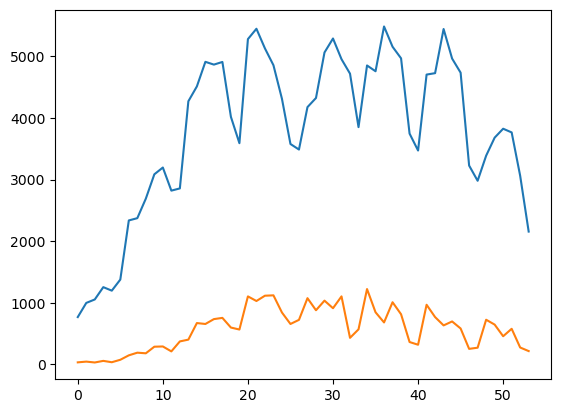

In [31]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [32]:
GPi = np.load('EuropeCovid2_GPi.npz')

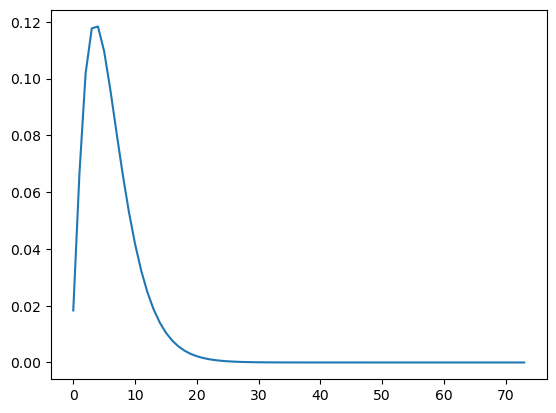

In [35]:
# g
g = np.zeros(T+T0)
g[:np.minimum(T+T0, GPi['g'].shape[0])] = GPi['g'][:np.minimum(T+T0, GPi['g'].shape[0])]
plt.plot(g)

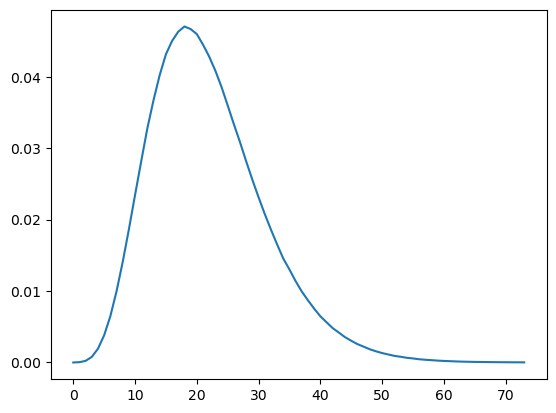

In [36]:
# pi
pi = np.zeros(T+T0)
pi[:np.minimum(T+T0, GPi['g'].shape[0])] = GPi['pi'][:np.minimum(T+T0, GPi['g'].shape[0])]
plt.plot(pi)

In [37]:
# A
d=2
A = np.zeros([T+T0, d])

In [38]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

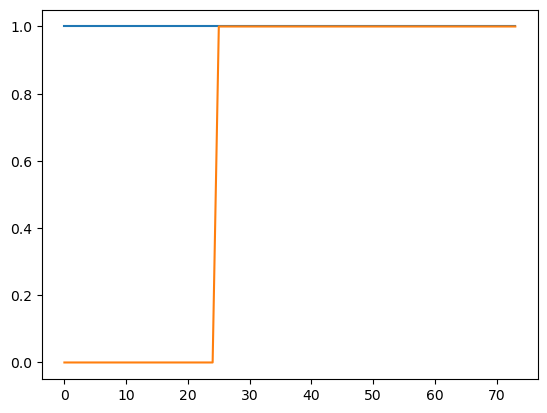

In [39]:
plt.plot(A)

# 3. fit by EM algorithm

In [43]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    ss=np.inf
    
    # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2)
        # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = mhat_0 * Pi_inv_ImG[:,0]
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([ss, step_size/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [44]:
mmle_0 = 17.4
smle_eps = 138.5
bmle = [0.207, 1.872]

In [45]:
mhs_0, shs_eps, bhs =\
    fit(Y_data, mmle_0, smle_eps, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=0.05)

Before EM, shat_eps: 603.341411
1-th iteration finished, shat_eps: 179.454190, lapse: 0.003sec.
2-th iteration finished, shat_eps: 179.404515, lapse: 0.003sec.
3-th iteration finished, shat_eps: 179.402621, lapse: 0.002sec.
4-th iteration finished, shat_eps: 179.401998, lapse: 0.002sec.
5-th iteration finished, shat_eps: 179.401406, lapse: 0.009sec.
6-th iteration finished, shat_eps: 179.400816, lapse: 0.001sec.
7-th iteration finished, shat_eps: 179.400229, lapse: 0.001sec.
8-th iteration finished, shat_eps: 179.399644, lapse: 0.001sec.
9-th iteration finished, shat_eps: 179.399061, lapse: 0.001sec.
10-th iteration finished, shat_eps: 179.398481, lapse: 0.002sec.
11-th iteration finished, shat_eps: 179.397902, lapse: 0.002sec.
12-th iteration finished, shat_eps: 179.397326, lapse: 0.003sec.
13-th iteration finished, shat_eps: 179.396752, lapse: 0.001sec.
14-th iteration finished, shat_eps: 179.396180, lapse: 0.002sec.
15-th iteration finished, shat_eps: 179.395610, lapse: 0.002sec.
16

217-th iteration finished, shat_eps: 179.314530, lapse: 0.015sec.
218-th iteration finished, shat_eps: 179.314257, lapse: 0.004sec.
219-th iteration finished, shat_eps: 179.313984, lapse: 0.002sec.
220-th iteration finished, shat_eps: 179.313713, lapse: 0.002sec.
221-th iteration finished, shat_eps: 179.313443, lapse: 0.002sec.
222-th iteration finished, shat_eps: 179.313173, lapse: 0.002sec.
223-th iteration finished, shat_eps: 179.312904, lapse: 0.001sec.
224-th iteration finished, shat_eps: 179.312637, lapse: 0.001sec.
225-th iteration finished, shat_eps: 179.312370, lapse: 0.001sec.
226-th iteration finished, shat_eps: 179.312104, lapse: 0.001sec.
227-th iteration finished, shat_eps: 179.311839, lapse: 0.003sec.
228-th iteration finished, shat_eps: 179.311575, lapse: 0.003sec.
229-th iteration finished, shat_eps: 179.311312, lapse: 0.001sec.
230-th iteration finished, shat_eps: 179.311050, lapse: 0.001sec.
231-th iteration finished, shat_eps: 179.310789, lapse: 0.001sec.
232-th ite

349-th iteration finished, shat_eps: 179.285472, lapse: 0.004sec.
350-th iteration finished, shat_eps: 179.285298, lapse: 0.001sec.
351-th iteration finished, shat_eps: 179.285124, lapse: 0.001sec.
352-th iteration finished, shat_eps: 179.284951, lapse: 0.001sec.
353-th iteration finished, shat_eps: 179.284778, lapse: 0.001sec.
354-th iteration finished, shat_eps: 179.284606, lapse: 0.001sec.
355-th iteration finished, shat_eps: 179.284435, lapse: 0.001sec.
356-th iteration finished, shat_eps: 179.284264, lapse: 0.006sec.
357-th iteration finished, shat_eps: 179.284094, lapse: 0.001sec.
358-th iteration finished, shat_eps: 179.283924, lapse: 0.001sec.
359-th iteration finished, shat_eps: 179.283755, lapse: 0.001sec.
360-th iteration finished, shat_eps: 179.283586, lapse: 0.001sec.
361-th iteration finished, shat_eps: 179.283418, lapse: 0.001sec.
362-th iteration finished, shat_eps: 179.283251, lapse: 0.001sec.
363-th iteration finished, shat_eps: 179.283084, lapse: 0.001sec.
364-th ite

565-th iteration finished, shat_eps: 179.258467, lapse: 0.007sec.
566-th iteration finished, shat_eps: 179.258381, lapse: 0.004sec.
567-th iteration finished, shat_eps: 179.258295, lapse: 0.005sec.
568-th iteration finished, shat_eps: 179.258209, lapse: 0.002sec.
569-th iteration finished, shat_eps: 179.258124, lapse: 0.011sec.
570-th iteration finished, shat_eps: 179.258039, lapse: 0.003sec.
571-th iteration finished, shat_eps: 179.257954, lapse: 0.003sec.
572-th iteration finished, shat_eps: 179.257869, lapse: 0.001sec.
573-th iteration finished, shat_eps: 179.257785, lapse: 0.004sec.
574-th iteration finished, shat_eps: 179.257700, lapse: 0.001sec.
575-th iteration finished, shat_eps: 179.257617, lapse: 0.007sec.
576-th iteration finished, shat_eps: 179.257533, lapse: 0.002sec.
577-th iteration finished, shat_eps: 179.257450, lapse: 0.002sec.
578-th iteration finished, shat_eps: 179.257367, lapse: 0.001sec.
579-th iteration finished, shat_eps: 179.257284, lapse: 0.004sec.
580-th ite

791-th iteration finished, shat_eps: 179.244480, lapse: 0.004sec.
792-th iteration finished, shat_eps: 179.244437, lapse: 0.002sec.
793-th iteration finished, shat_eps: 179.244395, lapse: 0.002sec.
794-th iteration finished, shat_eps: 179.244352, lapse: 0.002sec.
795-th iteration finished, shat_eps: 179.244310, lapse: 0.002sec.
796-th iteration finished, shat_eps: 179.244268, lapse: 0.002sec.
797-th iteration finished, shat_eps: 179.244226, lapse: 0.002sec.
798-th iteration finished, shat_eps: 179.244184, lapse: 0.010sec.
799-th iteration finished, shat_eps: 179.244142, lapse: 0.001sec.
800-th iteration finished, shat_eps: 179.244101, lapse: 0.001sec.
801-th iteration finished, shat_eps: 179.244059, lapse: 0.001sec.
802-th iteration finished, shat_eps: 179.244018, lapse: 0.003sec.
803-th iteration finished, shat_eps: 179.243977, lapse: 0.002sec.
804-th iteration finished, shat_eps: 179.243936, lapse: 0.002sec.
805-th iteration finished, shat_eps: 179.243895, lapse: 0.001sec.
806-th ite

947-th iteration finished, shat_eps: 179.239176, lapse: 0.002sec.
948-th iteration finished, shat_eps: 179.239149, lapse: 0.002sec.
949-th iteration finished, shat_eps: 179.239123, lapse: 0.002sec.
950-th iteration finished, shat_eps: 179.239096, lapse: 0.004sec.
951-th iteration finished, shat_eps: 179.239070, lapse: 0.006sec.
952-th iteration finished, shat_eps: 179.239044, lapse: 0.001sec.
953-th iteration finished, shat_eps: 179.239018, lapse: 0.001sec.
954-th iteration finished, shat_eps: 179.238992, lapse: 0.001sec.
955-th iteration finished, shat_eps: 179.238966, lapse: 0.001sec.
956-th iteration finished, shat_eps: 179.238940, lapse: 0.001sec.
957-th iteration finished, shat_eps: 179.238914, lapse: 0.001sec.
958-th iteration finished, shat_eps: 179.238888, lapse: 0.010sec.
959-th iteration finished, shat_eps: 179.238862, lapse: 0.001sec.
960-th iteration finished, shat_eps: 179.238837, lapse: 0.001sec.
961-th iteration finished, shat_eps: 179.238811, lapse: 0.001sec.
962-th ite

1172-th iteration finished, shat_eps: 179.234817, lapse: 0.003sec.
1173-th iteration finished, shat_eps: 179.234804, lapse: 0.002sec.
1174-th iteration finished, shat_eps: 179.234790, lapse: 0.002sec.
1175-th iteration finished, shat_eps: 179.234776, lapse: 0.002sec.
1176-th iteration finished, shat_eps: 179.234763, lapse: 0.002sec.
1177-th iteration finished, shat_eps: 179.234750, lapse: 0.002sec.
1178-th iteration finished, shat_eps: 179.234736, lapse: 0.002sec.
1179-th iteration finished, shat_eps: 179.234723, lapse: 0.002sec.
1180-th iteration finished, shat_eps: 179.234709, lapse: 0.011sec.
1181-th iteration finished, shat_eps: 179.234696, lapse: 0.002sec.
1182-th iteration finished, shat_eps: 179.234683, lapse: 0.002sec.
1183-th iteration finished, shat_eps: 179.234670, lapse: 0.002sec.
1184-th iteration finished, shat_eps: 179.234657, lapse: 0.003sec.
1185-th iteration finished, shat_eps: 179.234643, lapse: 0.001sec.
1186-th iteration finished, shat_eps: 179.234630, lapse: 0.001

1325-th iteration finished, shat_eps: 179.233138, lapse: 0.002sec.
1326-th iteration finished, shat_eps: 179.233130, lapse: 0.002sec.
1327-th iteration finished, shat_eps: 179.233121, lapse: 0.002sec.
1328-th iteration finished, shat_eps: 179.233112, lapse: 0.012sec.
1329-th iteration finished, shat_eps: 179.233104, lapse: 0.001sec.
1330-th iteration finished, shat_eps: 179.233095, lapse: 0.001sec.
1331-th iteration finished, shat_eps: 179.233087, lapse: 0.002sec.
1332-th iteration finished, shat_eps: 179.233078, lapse: 0.002sec.
1333-th iteration finished, shat_eps: 179.233069, lapse: 0.002sec.
1334-th iteration finished, shat_eps: 179.233061, lapse: 0.003sec.
1335-th iteration finished, shat_eps: 179.233053, lapse: 0.002sec.
1336-th iteration finished, shat_eps: 179.233044, lapse: 0.001sec.
1337-th iteration finished, shat_eps: 179.233036, lapse: 0.001sec.
1338-th iteration finished, shat_eps: 179.233027, lapse: 0.001sec.
1339-th iteration finished, shat_eps: 179.233019, lapse: 0.001

1457-th iteration finished, shat_eps: 179.232185, lapse: 0.003sec.
1458-th iteration finished, shat_eps: 179.232179, lapse: 0.011sec.
1459-th iteration finished, shat_eps: 179.232173, lapse: 0.002sec.
1460-th iteration finished, shat_eps: 179.232167, lapse: 0.002sec.
1461-th iteration finished, shat_eps: 179.232161, lapse: 0.002sec.
1462-th iteration finished, shat_eps: 179.232155, lapse: 0.002sec.
1463-th iteration finished, shat_eps: 179.232149, lapse: 0.001sec.
1464-th iteration finished, shat_eps: 179.232144, lapse: 0.001sec.
1465-th iteration finished, shat_eps: 179.232138, lapse: 0.002sec.
1466-th iteration finished, shat_eps: 179.232132, lapse: 0.005sec.
1467-th iteration finished, shat_eps: 179.232126, lapse: 0.001sec.
1468-th iteration finished, shat_eps: 179.232120, lapse: 0.002sec.
1469-th iteration finished, shat_eps: 179.232115, lapse: 0.005sec.
1470-th iteration finished, shat_eps: 179.232109, lapse: 0.002sec.
1471-th iteration finished, shat_eps: 179.232103, lapse: 0.005

1679-th iteration finished, shat_eps: 179.231212, lapse: 0.017sec.
1680-th iteration finished, shat_eps: 179.231209, lapse: 0.009sec.
1681-th iteration finished, shat_eps: 179.231206, lapse: 0.007sec.
1682-th iteration finished, shat_eps: 179.231203, lapse: 0.001sec.
1683-th iteration finished, shat_eps: 179.231200, lapse: 0.001sec.
1684-th iteration finished, shat_eps: 179.231197, lapse: 0.001sec.
1685-th iteration finished, shat_eps: 179.231194, lapse: 0.001sec.
1686-th iteration finished, shat_eps: 179.231191, lapse: 0.001sec.
1687-th iteration finished, shat_eps: 179.231188, lapse: 0.003sec.
1688-th iteration finished, shat_eps: 179.231185, lapse: 0.009sec.
1689-th iteration finished, shat_eps: 179.231182, lapse: 0.002sec.
1690-th iteration finished, shat_eps: 179.231179, lapse: 0.001sec.
1691-th iteration finished, shat_eps: 179.231176, lapse: 0.001sec.
1692-th iteration finished, shat_eps: 179.231173, lapse: 0.001sec.
1693-th iteration finished, shat_eps: 179.231170, lapse: 0.006

1806-th iteration finished, shat_eps: 179.230879, lapse: 0.002sec.
1807-th iteration finished, shat_eps: 179.230877, lapse: 0.002sec.
1808-th iteration finished, shat_eps: 179.230875, lapse: 0.003sec.
1809-th iteration finished, shat_eps: 179.230873, lapse: 0.002sec.
1810-th iteration finished, shat_eps: 179.230871, lapse: 0.005sec.
1811-th iteration finished, shat_eps: 179.230869, lapse: 0.011sec.
1812-th iteration finished, shat_eps: 179.230866, lapse: 0.001sec.
1813-th iteration finished, shat_eps: 179.230864, lapse: 0.002sec.
1814-th iteration finished, shat_eps: 179.230862, lapse: 0.003sec.
1815-th iteration finished, shat_eps: 179.230860, lapse: 0.002sec.
1816-th iteration finished, shat_eps: 179.230858, lapse: 0.023sec.
1817-th iteration finished, shat_eps: 179.230856, lapse: 0.002sec.
1818-th iteration finished, shat_eps: 179.230854, lapse: 0.008sec.
1819-th iteration finished, shat_eps: 179.230852, lapse: 0.002sec.
1820-th iteration finished, shat_eps: 179.230849, lapse: 0.001

2048-th iteration finished, shat_eps: 179.230499, lapse: 0.002sec.
2049-th iteration finished, shat_eps: 179.230498, lapse: 0.002sec.
2050-th iteration finished, shat_eps: 179.230497, lapse: 0.002sec.
2051-th iteration finished, shat_eps: 179.230495, lapse: 0.011sec.
2052-th iteration finished, shat_eps: 179.230494, lapse: 0.001sec.
2053-th iteration finished, shat_eps: 179.230493, lapse: 0.005sec.
2054-th iteration finished, shat_eps: 179.230492, lapse: 0.002sec.
2055-th iteration finished, shat_eps: 179.230491, lapse: 0.002sec.
2056-th iteration finished, shat_eps: 179.230490, lapse: 0.002sec.
2057-th iteration finished, shat_eps: 179.230489, lapse: 0.002sec.
2058-th iteration finished, shat_eps: 179.230488, lapse: 0.001sec.
2059-th iteration finished, shat_eps: 179.230487, lapse: 0.001sec.
2060-th iteration finished, shat_eps: 179.230486, lapse: 0.001sec.
2061-th iteration finished, shat_eps: 179.230485, lapse: 0.001sec.
2062-th iteration finished, shat_eps: 179.230484, lapse: 0.001

2312-th iteration finished, shat_eps: 179.230295, lapse: 0.003sec.
2313-th iteration finished, shat_eps: 179.230295, lapse: 0.013sec.
2314-th iteration finished, shat_eps: 179.230294, lapse: 0.004sec.
2315-th iteration finished, shat_eps: 179.230294, lapse: 0.001sec.
2316-th iteration finished, shat_eps: 179.230293, lapse: 0.001sec.
2317-th iteration finished, shat_eps: 179.230293, lapse: 0.003sec.
2318-th iteration finished, shat_eps: 179.230292, lapse: 0.004sec.
2319-th iteration finished, shat_eps: 179.230292, lapse: 0.002sec.
2320-th iteration finished, shat_eps: 179.230291, lapse: 0.005sec.
2321-th iteration finished, shat_eps: 179.230291, lapse: 0.002sec.
2322-th iteration finished, shat_eps: 179.230290, lapse: 0.003sec.
2323-th iteration finished, shat_eps: 179.230290, lapse: 0.002sec.
2324-th iteration finished, shat_eps: 179.230289, lapse: 0.002sec.
2325-th iteration finished, shat_eps: 179.230289, lapse: 0.001sec.
2326-th iteration finished, shat_eps: 179.230288, lapse: 0.002

2508-th iteration finished, shat_eps: 179.230217, lapse: 0.002sec.
2509-th iteration finished, shat_eps: 179.230217, lapse: 0.040sec.
2510-th iteration finished, shat_eps: 179.230217, lapse: 0.001sec.
2511-th iteration finished, shat_eps: 179.230217, lapse: 0.001sec.
2512-th iteration finished, shat_eps: 179.230216, lapse: 0.001sec.
2513-th iteration finished, shat_eps: 179.230216, lapse: 0.001sec.
2514-th iteration finished, shat_eps: 179.230216, lapse: 0.001sec.
2515-th iteration finished, shat_eps: 179.230215, lapse: 0.002sec.
2516-th iteration finished, shat_eps: 179.230215, lapse: 0.003sec.
2517-th iteration finished, shat_eps: 179.230215, lapse: 0.002sec.
2518-th iteration finished, shat_eps: 179.230215, lapse: 0.002sec.
2519-th iteration finished, shat_eps: 179.230214, lapse: 0.002sec.
2520-th iteration finished, shat_eps: 179.230214, lapse: 0.001sec.
2521-th iteration finished, shat_eps: 179.230214, lapse: 0.001sec.
2522-th iteration finished, shat_eps: 179.230213, lapse: 0.001

2642-th iteration finished, shat_eps: 179.230184, lapse: 0.002sec.
2643-th iteration finished, shat_eps: 179.230184, lapse: 0.011sec.
2644-th iteration finished, shat_eps: 179.230184, lapse: 0.002sec.
2645-th iteration finished, shat_eps: 179.230184, lapse: 0.002sec.
2646-th iteration finished, shat_eps: 179.230183, lapse: 0.002sec.
2647-th iteration finished, shat_eps: 179.230183, lapse: 0.002sec.
2648-th iteration finished, shat_eps: 179.230183, lapse: 0.002sec.
2649-th iteration finished, shat_eps: 179.230183, lapse: 0.003sec.
2650-th iteration finished, shat_eps: 179.230183, lapse: 0.001sec.
2651-th iteration finished, shat_eps: 179.230182, lapse: 0.001sec.
2652-th iteration finished, shat_eps: 179.230182, lapse: 0.001sec.
2653-th iteration finished, shat_eps: 179.230182, lapse: 0.001sec.
2654-th iteration finished, shat_eps: 179.230182, lapse: 0.001sec.
2655-th iteration finished, shat_eps: 179.230182, lapse: 0.001sec.
2656-th iteration finished, shat_eps: 179.230181, lapse: 0.001

2779-th iteration finished, shat_eps: 179.230161, lapse: 0.003sec.
2780-th iteration finished, shat_eps: 179.230161, lapse: 0.012sec.
2781-th iteration finished, shat_eps: 179.230161, lapse: 0.002sec.
2782-th iteration finished, shat_eps: 179.230161, lapse: 0.002sec.
2783-th iteration finished, shat_eps: 179.230160, lapse: 0.002sec.
2784-th iteration finished, shat_eps: 179.230160, lapse: 0.002sec.
2785-th iteration finished, shat_eps: 179.230160, lapse: 0.003sec.
2786-th iteration finished, shat_eps: 179.230160, lapse: 0.001sec.
2787-th iteration finished, shat_eps: 179.230160, lapse: 0.001sec.
2788-th iteration finished, shat_eps: 179.230160, lapse: 0.001sec.
2789-th iteration finished, shat_eps: 179.230160, lapse: 0.001sec.
2790-th iteration finished, shat_eps: 179.230159, lapse: 0.001sec.
2791-th iteration finished, shat_eps: 179.230159, lapse: 0.001sec.
2792-th iteration finished, shat_eps: 179.230159, lapse: 0.001sec.
2793-th iteration finished, shat_eps: 179.230159, lapse: 0.001

2920-th iteration finished, shat_eps: 179.230145, lapse: 0.012sec.
2921-th iteration finished, shat_eps: 179.230145, lapse: 0.003sec.
2922-th iteration finished, shat_eps: 179.230145, lapse: 0.002sec.
2923-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2924-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2925-th iteration finished, shat_eps: 179.230144, lapse: 0.005sec.
2926-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2927-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2928-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2929-th iteration finished, shat_eps: 179.230144, lapse: 0.002sec.
2930-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2931-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2932-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2933-th iteration finished, shat_eps: 179.230144, lapse: 0.001sec.
2934-th iteration finished, shat_eps: 179.230143, lapse: 0.001

3060-th iteration finished, shat_eps: 179.230134, lapse: 0.001sec.
3061-th iteration finished, shat_eps: 179.230134, lapse: 0.011sec.
3062-th iteration finished, shat_eps: 179.230134, lapse: 0.001sec.
3063-th iteration finished, shat_eps: 179.230134, lapse: 0.001sec.
3064-th iteration finished, shat_eps: 179.230134, lapse: 0.001sec.
3065-th iteration finished, shat_eps: 179.230134, lapse: 0.001sec.
3066-th iteration finished, shat_eps: 179.230133, lapse: 0.001sec.
3067-th iteration finished, shat_eps: 179.230133, lapse: 0.001sec.
3068-th iteration finished, shat_eps: 179.230133, lapse: 0.001sec.
3069-th iteration finished, shat_eps: 179.230133, lapse: 0.001sec.
3070-th iteration finished, shat_eps: 179.230133, lapse: 0.003sec.
3071-th iteration finished, shat_eps: 179.230133, lapse: 0.002sec.
3072-th iteration finished, shat_eps: 179.230133, lapse: 0.002sec.
3073-th iteration finished, shat_eps: 179.230133, lapse: 0.002sec.
3074-th iteration finished, shat_eps: 179.230133, lapse: 0.002

3202-th iteration finished, shat_eps: 179.230126, lapse: 0.002sec.
3203-th iteration finished, shat_eps: 179.230126, lapse: 0.002sec.
3204-th iteration finished, shat_eps: 179.230126, lapse: 0.013sec.
3205-th iteration finished, shat_eps: 179.230126, lapse: 0.002sec.
3206-th iteration finished, shat_eps: 179.230126, lapse: 0.003sec.
3207-th iteration finished, shat_eps: 179.230126, lapse: 0.002sec.
3208-th iteration finished, shat_eps: 179.230126, lapse: 0.002sec.
3209-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3210-th iteration finished, shat_eps: 179.230126, lapse: 0.004sec.
3211-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3212-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3213-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3214-th iteration finished, shat_eps: 179.230126, lapse: 0.002sec.
3215-th iteration finished, shat_eps: 179.230126, lapse: 0.001sec.
3216-th iteration finished, shat_eps: 179.230126, lapse: 0.001

3367-th iteration finished, shat_eps: 179.230121, lapse: 0.012sec.
3368-th iteration finished, shat_eps: 179.230121, lapse: 0.004sec.
3369-th iteration finished, shat_eps: 179.230121, lapse: 0.002sec.
3370-th iteration finished, shat_eps: 179.230121, lapse: 0.002sec.
3371-th iteration finished, shat_eps: 179.230121, lapse: 0.004sec.
3372-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3373-th iteration finished, shat_eps: 179.230121, lapse: 0.003sec.
3374-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3375-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3376-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3377-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3378-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3379-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3380-th iteration finished, shat_eps: 179.230121, lapse: 0.001sec.
3381-th iteration finished, shat_eps: 179.230120, lapse: 0.002

3527-th iteration finished, shat_eps: 179.230117, lapse: 0.001sec.
3528-th iteration finished, shat_eps: 179.230117, lapse: 0.002sec.
3529-th iteration finished, shat_eps: 179.230117, lapse: 0.002sec.
3530-th iteration finished, shat_eps: 179.230117, lapse: 0.002sec.
3531-th iteration finished, shat_eps: 179.230117, lapse: 0.002sec.
3532-th iteration finished, shat_eps: 179.230117, lapse: 0.011sec.
3533-th iteration finished, shat_eps: 179.230117, lapse: 0.003sec.
3534-th iteration finished, shat_eps: 179.230117, lapse: 0.002sec.
3535-th iteration finished, shat_eps: 179.230117, lapse: 0.002sec.
3536-th iteration finished, shat_eps: 179.230117, lapse: 0.002sec.
3537-th iteration finished, shat_eps: 179.230117, lapse: 0.004sec.
3538-th iteration finished, shat_eps: 179.230117, lapse: 0.001sec.
3539-th iteration finished, shat_eps: 179.230117, lapse: 0.001sec.
3540-th iteration finished, shat_eps: 179.230117, lapse: 0.001sec.
3541-th iteration finished, shat_eps: 179.230117, lapse: 0.001

3746-th iteration finished, shat_eps: 179.230115, lapse: 0.007sec.
3747-th iteration finished, shat_eps: 179.230115, lapse: 0.002sec.
3748-th iteration finished, shat_eps: 179.230115, lapse: 0.003sec.
3749-th iteration finished, shat_eps: 179.230115, lapse: 0.002sec.
3750-th iteration finished, shat_eps: 179.230115, lapse: 0.002sec.
3751-th iteration finished, shat_eps: 179.230115, lapse: 0.013sec.
3752-th iteration finished, shat_eps: 179.230115, lapse: 0.002sec.
3753-th iteration finished, shat_eps: 179.230115, lapse: 0.002sec.
3754-th iteration finished, shat_eps: 179.230115, lapse: 0.002sec.
3755-th iteration finished, shat_eps: 179.230115, lapse: 0.004sec.
3756-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3757-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3758-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3759-th iteration finished, shat_eps: 179.230114, lapse: 0.001sec.
3760-th iteration finished, shat_eps: 179.230114, lapse: 0.001

3884-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3885-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3886-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3887-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3888-th iteration finished, shat_eps: 179.230114, lapse: 0.002sec.
3889-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
3890-th iteration finished, shat_eps: 179.230113, lapse: 0.012sec.
3891-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3892-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3893-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3894-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3895-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3896-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3897-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
3898-th iteration finished, shat_eps: 179.230113, lapse: 0.001

4028-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4029-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
4030-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4031-th iteration finished, shat_eps: 179.230113, lapse: 0.022sec.
4032-th iteration finished, shat_eps: 179.230113, lapse: 0.006sec.
4033-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
4034-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
4035-th iteration finished, shat_eps: 179.230113, lapse: 0.003sec.
4036-th iteration finished, shat_eps: 179.230113, lapse: 0.002sec.
4037-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4038-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4039-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4040-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4041-th iteration finished, shat_eps: 179.230113, lapse: 0.001sec.
4042-th iteration finished, shat_eps: 179.230113, lapse: 0.001

4166-th iteration finished, shat_eps: 179.230112, lapse: 0.015sec.
4167-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4168-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4169-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4170-th iteration finished, shat_eps: 179.230112, lapse: 0.004sec.
4171-th iteration finished, shat_eps: 179.230112, lapse: 0.005sec.
4172-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4173-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4174-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4175-th iteration finished, shat_eps: 179.230112, lapse: 0.004sec.
4176-th iteration finished, shat_eps: 179.230112, lapse: 0.004sec.
4177-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4178-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4179-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4180-th iteration finished, shat_eps: 179.230112, lapse: 0.001

4385-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4386-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4387-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4388-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4389-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4390-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4391-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4392-th iteration finished, shat_eps: 179.230112, lapse: 0.006sec.
4393-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4394-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4395-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4396-th iteration finished, shat_eps: 179.230112, lapse: 0.004sec.
4397-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4398-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4399-th iteration finished, shat_eps: 179.230112, lapse: 0.001

4577-th iteration finished, shat_eps: 179.230112, lapse: 0.040sec.
4578-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4579-th iteration finished, shat_eps: 179.230112, lapse: 0.005sec.
4580-th iteration finished, shat_eps: 179.230112, lapse: 0.013sec.
4581-th iteration finished, shat_eps: 179.230112, lapse: 0.004sec.
4582-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4583-th iteration finished, shat_eps: 179.230112, lapse: 0.001sec.
4584-th iteration finished, shat_eps: 179.230112, lapse: 0.003sec.
4585-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4586-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4587-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4588-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4589-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4590-th iteration finished, shat_eps: 179.230112, lapse: 0.002sec.
4591-th iteration finished, shat_eps: 179.230112, lapse: 0.001

4798-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
4799-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4800-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4801-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4802-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4803-th iteration finished, shat_eps: 179.230111, lapse: 0.012sec.
4804-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4805-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
4806-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4807-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4808-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4809-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4810-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
4811-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4812-th iteration finished, shat_eps: 179.230111, lapse: 0.001

4931-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
4932-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
4933-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4934-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4935-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4936-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4937-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4938-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4939-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4940-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
4941-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4942-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4943-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4944-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
4945-th iteration finished, shat_eps: 179.230111, lapse: 0.003

5127-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
5128-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5129-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5130-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5131-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5132-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5133-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5134-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5135-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5136-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5137-th iteration finished, shat_eps: 179.230111, lapse: 0.016sec.
5138-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5139-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5140-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5141-th iteration finished, shat_eps: 179.230111, lapse: 0.002

5335-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5336-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5337-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
5338-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5339-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5340-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5341-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5342-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5343-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5344-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5345-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5346-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5347-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5348-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5349-th iteration finished, shat_eps: 179.230111, lapse: 0.002

5459-th iteration finished, shat_eps: 179.230111, lapse: 0.044sec.
5460-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
5461-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5462-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5463-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5464-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5465-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5466-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5467-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5468-th iteration finished, shat_eps: 179.230111, lapse: 0.009sec.
5469-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5470-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5471-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5472-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
5473-th iteration finished, shat_eps: 179.230111, lapse: 0.001

5585-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5586-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5587-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5588-th iteration finished, shat_eps: 179.230111, lapse: 0.012sec.
5589-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5590-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5591-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5592-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5593-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5594-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5595-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5596-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5597-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5598-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5599-th iteration finished, shat_eps: 179.230111, lapse: 0.001

5851-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5852-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5853-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5854-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
5855-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
5856-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5857-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5858-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5859-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5860-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
5861-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5862-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
5863-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5864-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
5865-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6111-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6112-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6113-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6114-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6115-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6116-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6117-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
6118-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6119-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6120-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6121-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6122-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6123-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6124-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6125-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6377-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6378-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6379-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6380-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6381-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6382-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6383-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6384-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6385-th iteration finished, shat_eps: 179.230111, lapse: 0.016sec.
6386-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6387-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6388-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6389-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6390-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6391-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6504-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6505-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6506-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
6507-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
6508-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6509-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6510-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6511-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6512-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6513-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6514-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6515-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6516-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6517-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6518-th iteration finished, shat_eps: 179.230111, lapse: 0.002

6669-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
6670-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6671-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6672-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6673-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6674-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6675-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6676-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6677-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6678-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6679-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6680-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6681-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6682-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
6683-th iteration finished, shat_eps: 179.230111, lapse: 0.006

6814-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6815-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6816-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6817-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6818-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6819-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
6820-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6821-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6822-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6823-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6824-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
6825-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6826-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6827-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6828-th iteration finished, shat_eps: 179.230111, lapse: 0.001

6959-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6960-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6961-th iteration finished, shat_eps: 179.230111, lapse: 0.009sec.
6962-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
6963-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6964-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6965-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6966-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6967-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6968-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
6969-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6970-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6971-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6972-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
6973-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7227-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7228-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
7229-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7230-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7231-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7232-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7233-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7234-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7235-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7236-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7237-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7238-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7239-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7240-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7241-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7504-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7505-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7506-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7507-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7508-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7509-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7510-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7511-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7512-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7513-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
7514-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
7515-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7516-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7517-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7518-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7636-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
7637-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7638-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7639-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7640-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7641-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7642-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
7643-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7644-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7645-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7646-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7647-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7648-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7649-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7650-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7794-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7795-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7796-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7797-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7798-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7799-th iteration finished, shat_eps: 179.230111, lapse: 0.023sec.
7800-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
7801-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
7802-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7803-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7804-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
7805-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7806-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
7807-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7808-th iteration finished, shat_eps: 179.230111, lapse: 0.001

7936-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7937-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7938-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7939-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7940-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7941-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7942-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7943-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7944-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7945-th iteration finished, shat_eps: 179.230111, lapse: 0.012sec.
7946-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
7947-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7948-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
7949-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
7950-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8206-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
8207-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
8208-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8209-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
8210-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8211-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8212-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8213-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8214-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8215-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8216-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8217-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8218-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8219-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8220-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8470-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8471-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8472-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
8473-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8474-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
8475-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8476-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8477-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8478-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8479-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8480-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8481-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8482-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8483-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8484-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8610-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
8611-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8612-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8613-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
8614-th iteration finished, shat_eps: 179.230111, lapse: 0.012sec.
8615-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8616-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8617-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8618-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8619-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
8620-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8621-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8622-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8623-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8624-th iteration finished, shat_eps: 179.230111, lapse: 0.001

8757-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8758-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
8759-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
8760-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8761-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8762-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8763-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8764-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8765-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8766-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8767-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8768-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8769-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8770-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8771-th iteration finished, shat_eps: 179.230111, lapse: 0.002

8909-th iteration finished, shat_eps: 179.230111, lapse: 0.016sec.
8910-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8911-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8912-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8913-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8914-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8915-th iteration finished, shat_eps: 179.230111, lapse: 0.016sec.
8916-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8917-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8918-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8919-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
8920-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8921-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8922-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
8923-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9059-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9060-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9061-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9062-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
9063-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9064-th iteration finished, shat_eps: 179.230111, lapse: 0.011sec.
9065-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
9066-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9067-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9068-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9069-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9070-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9071-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9072-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9073-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9204-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9205-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9206-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9207-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9208-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9209-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9210-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9211-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9212-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9213-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
9214-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9215-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9216-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9217-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9218-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9357-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9358-th iteration finished, shat_eps: 179.230111, lapse: 0.013sec.
9359-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9360-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9361-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9362-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9363-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9364-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9365-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9366-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9367-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9368-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9369-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9370-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9371-th iteration finished, shat_eps: 179.230111, lapse: 0.001

9485-th iteration finished, shat_eps: 179.230111, lapse: 0.012sec.
9486-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9487-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9488-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9489-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9490-th iteration finished, shat_eps: 179.230111, lapse: 0.004sec.
9491-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9492-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9493-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9494-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9495-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9496-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9497-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9498-th iteration finished, shat_eps: 179.230111, lapse: 0.006sec.
9499-th iteration finished, shat_eps: 179.230111, lapse: 0.003

9683-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
9684-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
9685-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9686-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9687-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9688-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9689-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9690-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9691-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9692-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9693-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9694-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9695-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9696-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9697-th iteration finished, shat_eps: 179.230111, lapse: 0.003

9842-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9843-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9844-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9845-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9846-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9847-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9848-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9849-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9850-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9851-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9852-th iteration finished, shat_eps: 179.230111, lapse: 0.010sec.
9853-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9854-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9855-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9856-th iteration finished, shat_eps: 179.230111, lapse: 0.003

9971-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9972-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9973-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9974-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9975-th iteration finished, shat_eps: 179.230111, lapse: 0.005sec.
9976-th iteration finished, shat_eps: 179.230111, lapse: 0.008sec.
9977-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9978-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9979-th iteration finished, shat_eps: 179.230111, lapse: 0.007sec.
9980-th iteration finished, shat_eps: 179.230111, lapse: 0.001sec.
9981-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9982-th iteration finished, shat_eps: 179.230111, lapse: 0.003sec.
9983-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9984-th iteration finished, shat_eps: 179.230111, lapse: 0.002sec.
9985-th iteration finished, shat_eps: 179.230111, lapse: 0.002

In [46]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

In [47]:
mmle_0, smle_eps, bmle

(117.13773104538512, 179.2301112686109, array([0.06931485, 2.06645474]))

## plots

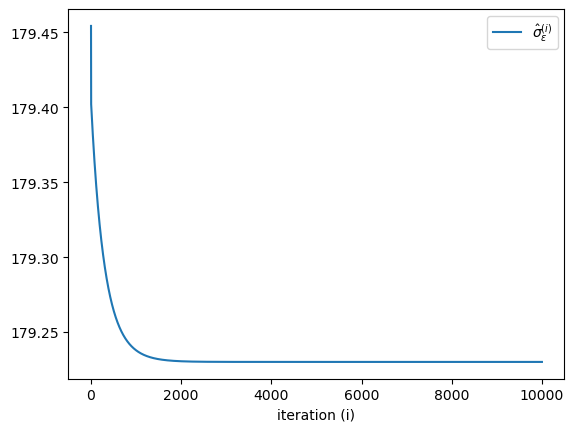

In [48]:
plt.plot(shs_eps, label=r"$\hat{\sigma}^{(i)}_\epsilon$")
plt.xlabel("iteration (i)"); plt.legend()

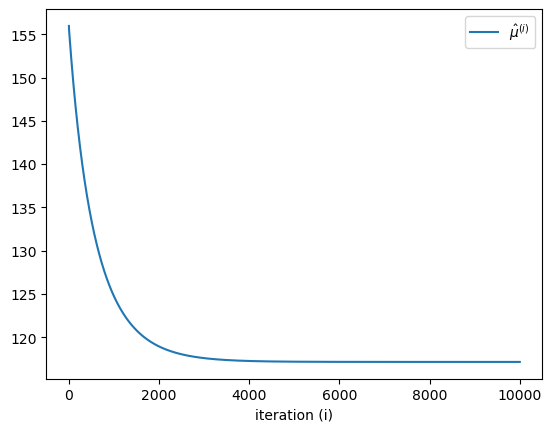

In [49]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

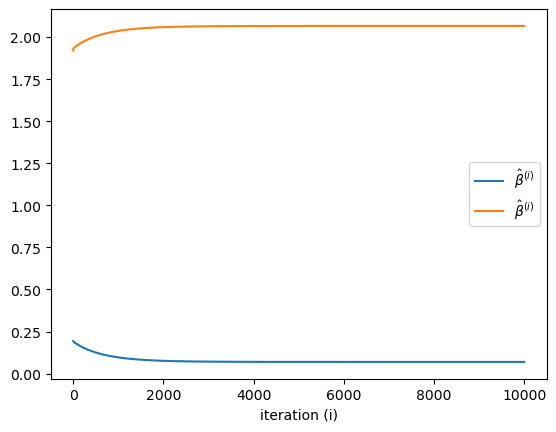

In [50]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Wald's Confidence Region

In [51]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [52]:
for t in np.arange(T+T0):
    o = np.exp(bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = - K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

In [53]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [54]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [55]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [56]:
Pi_inv_ImG = Pi @ inv_ImG

In [57]:
EY = mmle_0 * Pi_inv_ImG[:,0]

In [58]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [59]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [60]:
Ed2l_ds2 = - 2 * T / smle_eps**2
Ed2l_dsdm = 0
Ed2l_dsdb = np.zeros(d)
Ed2l_dm2 = - np.sum(Pi_inv_ImG[:,0]**2) / smle_eps**2
Ed2l_dmdb = - np.sum(Pi_inv_ImG[:,0] * d1EY, 1) / smle_eps**2
Ed2l_db2 = - d1EY @ d1EY.T / smle_eps**2

In [61]:
Ed2l_dms2 = np.array(
    [[Ed2l_dm2, Ed2l_dsdm],
     [Ed2l_dsdm, Ed2l_ds2]]
)
Ed2l_dmsdb = np.stack([Ed2l_dmdb, Ed2l_dsdb])

In [62]:
Ihat_dth = - np.block(
    [[Ed2l_dms2, Ed2l_dmsdb],
     [Ed2l_dmsdb.T, Ed2l_db2]])

In [63]:
Ihat_dth

array([[ 5.14994528e-02, -0.00000000e+00, -1.97147010e+01,
        -5.19090310e+00],
       [-0.00000000e+00,  3.36203172e-03, -0.00000000e+00,
        -0.00000000e+00],
       [-1.97147010e+01, -0.00000000e+00,  7.94458384e+03,
         2.34183703e+03],
       [-5.19090310e+00, -0.00000000e+00,  2.34183703e+03,
         8.44514315e+02]])

In [64]:
la.inv(Ihat_dth)[-2:,-2:]

array([[ 0.16738775, -0.18478426],
       [-0.18478426,  0.20710117]])

In [65]:
np.sqrt(la.inv(Ihat_dth)[2,2])

0.4091304855263107

In [66]:
np.sqrt(la.inv(Ihat_dth)[3,3])

0.45508369982577385

# 5. HAC estimator

In [67]:
# Ed2l_ds2 = T / smle_eps**2 - 3 * (Y_data-EY) @ w_HAC @ (Y_data-EY) / smle_eps**4
# Ed2l_dsdm = - 2 * Pi_inv_ImG[:,0] @ w_HAC @ (Y_data-EY) / smle_eps**3
# Ed2l_dsdb = - 2 * d1EY @ w_HAC @ (Y_data-EY) / smle_eps**3
# Ed2l_dm2 = - Pi_inv_ImG[:,0] @ w_HAC @ Pi_inv_ImG[:,0] / smle_eps**2
# Ed2l_dmdb = - d1EY @ w_HAC @ Pi_inv_ImG[:,0] / smle_eps**2
# Ed2l_db2 = - d1EY @ w_HAC @ d1EY.T / smle_eps**2

In [68]:
# Ed2l_dms2 = np.array(
#     [[Ed2l_dm2, Ed2l_dsdm],
#      [Ed2l_dsdm, Ed2l_ds2]]
# )
# Ed2l_dmsdb = np.stack([Ed2l_dmdb, Ed2l_dsdb])

In [69]:
# Ihat_HAC = - np.block(
#     [[Ed2l_dms2, Ed2l_dmsdb],
#      [Ed2l_dmsdb.T, Ed2l_db2]])

In [70]:
# Ihat_HAC

# 6. Sandwich estimator

In [71]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [72]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [73]:
dlt_dm = Pi_inv_ImG[:,0] * (Y_data - EY) / smle_eps**2
dlt_dsp = - 1 / smle_eps + (Y_data - EY)**2 / smle_eps**3
dlt_db = d1EY * (Y_data - EY) / smle_eps**2

In [74]:
dlt_dth = np.concatenate([np.array([dlt_dm, dlt_dsp]), dlt_db], 0)

In [75]:
VEdl = dlt_dth @ w_HAC @ dlt_dth.T

In [76]:
VEdl

array([[ 5.96465944e-02, -6.64667526e-03, -2.27879997e+01,
        -5.85224074e+00],
       [-6.64667526e-03,  5.15847371e-03,  2.74827213e+00,
         8.25841122e-01],
       [-2.27879997e+01,  2.74827213e+00,  9.09129150e+03,
         2.59325769e+03],
       [-5.85224074e+00,  8.25841122e-01,  2.59325769e+03,
         9.07140872e+02]])

In [77]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [78]:
Ihat_sdw

array([[ 5.69206069e-02,  3.49650397e-03, -2.11497928e+01,
        -5.47337850e+00],
       [ 3.49650397e-03,  2.83778221e-03, -1.71178644e+00,
        -6.20547994e-01],
       [-2.11497928e+01, -1.71178644e+00,  8.47056254e+03,
         2.52044831e+03],
       [-5.47337850e+00, -6.20547994e-01,  2.52044831e+03,
         9.25889349e+02]])

In [79]:
Ihat_dth

array([[ 5.14994528e-02, -0.00000000e+00, -1.97147010e+01,
        -5.19090310e+00],
       [-0.00000000e+00,  3.36203172e-03, -0.00000000e+00,
        -0.00000000e+00],
       [-1.97147010e+01, -0.00000000e+00,  7.94458384e+03,
         2.34183703e+03],
       [-5.19090310e+00, -0.00000000e+00,  2.34183703e+03,
         8.44514315e+02]])

In [80]:
la.inv(Ihat_sdw)[-2:,-2:]

array([[ 0.05773792, -0.06920537],
       [-0.06920537,  0.0856622 ]])

In [81]:
np.sqrt(la.inv(Ihat_sdw)[2,2])

0.24028715538508522

In [82]:
np.sqrt(la.inv(Ihat_sdw)[3,3])

0.29268105350702833